# InceptionV3 + LSTM video classifier

## Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preparing the dataset

### Dividing into training, test and validation

In [ ]:
pip install split-folders

In [ ]:
%cd '/content/drive/MyDrive/fight-detection'

/content/drive/MyDrive/fight-detection


In [ ]:
import splitfolders 
splitfolders.ratio('data/data_og', output="data", seed=2023, ratio=(.7, 0.2,0.1))

Copying files: 300 files [00:09, 31.67 files/s]


## Cloning the LSTM-video-classification repository

In [ ]:
%cd data

/content/drive/MyDrive/fight-detection/data


In [ ]:
!python extract_files.py mp4

The file data/data_file.csv contains the duration (number of frames) of the videos. To classify all of them choose for the training a sequence lenght of the minimum duration

## Data Augmentation

In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img

DATA_AUG_TRUE=0

if DATA_AUG_TRUE:
  ### Fights
  # load the list of images
  path='./train/fight/'
  images = os.listdir(path)

  images_filter=[name for name in images if (name.find('.mp4') or name.find('f_') )== -1]
  images=images_filter
  print(images)

  # apply flip
  for i, img_name in enumerate(images):
      #print(img_name)
      image = load_img(path+img_name)
      image_array = img_to_array(image)
      transformed_image_array = tf.image.flip_left_right(image_array)
      transformed_image = tf.keras.preprocessing.image.array_to_img(transformed_image_array)
      save_img(f'{path}f_{img_name.replace(".jpg","")}.jpg', transformed_image)

  ### No Fights

  # load the list of images
  #images = ['fi001-0001.jpg', 'fi001-0002.jpg', 'fi001-0003.jpg']
  path='./train/noFight/'
  images = os.listdir(path)

  images_filter=[name for name in images if (name.find('.mp4') or name.find('f_') )== -1]
  images=images_filter

  # apply flip
  for i, img_name in enumerate(images):
      image = load_img(path+img_name)
      image_array = img_to_array(image)
      transformed_image_array = tf.image.flip_left_right(image_array)
      transformed_image = tf.keras.preprocessing.image.array_to_img(transformed_image_array)
      save_img(f'{path}f_{img_name.replace(".jpg","")}.jpg', transformed_image)


## Training

In [ ]:
import pandas as pd
df = pd.read_csv('data_file.csv',header=None)

In [ ]:
df.head()

,train,noFight,nofi039,seq_len
0,train,noFight,nofi023,63
1,train,noFight,nofi086,36
2,train,noFight,nofi029,48
3,train,noFight,nofi056,50
4,train,noFight,nofi070,42


In [ ]:
df.describe()

count    299.000000
mean      57.046823
std       15.955827
min       20.000000
25%       50.000000
50%       60.000000
75%       60.000000
max      142.000000
Name: seq_len, dtype: float64

In [ ]:
%cd data

/content/drive/MyDrive/fight-detection/data


In [ ]:
import glob
import os
import cv2

folders = ['train', 'test', 'val']
extenssion = 'jpg'

for folder in folders:
    class_folders = glob.glob(os.path.join(folder, '*'))
    print(class_folders)

    for vid_class in class_folders:
        class_files = glob.glob(os.path.join(vid_class, '*.' + extenssion))
        print(class_files)

        for video_path in class_files:
          img = cv2.imread(video_path, cv2.IMREAD_UNCHANGED)
          resized = cv2.resize(img, (256,256), interpolation=cv2.INTER_CUBIC)
          cv2.imwrite(video_path, resized)



```
! python train.py 43 2 480 640
```



In [ ]:
%cd .. 

/content/drive/MyDrive/fight-detection


In [ ]:
!python train.py 20 2 128 128

2023-03-23 18:41:45.118048: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-23 18:41:46.404244: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.9/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-03-23 18:41:46.404371: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.9/dist-packages/cv2/../../lib64:/u

## Evaluating

```
! python predict.py 43 2 lstm_features.hdf5 train
```



In [ ]:
!python predict.py 20 2  'data/checkpoints/lstm-features.009-0.570.hdf5' val 128 128

2023-03-23 17:17:24.115115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-23 17:17:25.243054: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.9/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-03-23 17:17:25.243172: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.9/dist-packages/cv2/../../lib64:/u

#### Calculate metrics

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score

# Load the Excel file into a Pandas dataframe
df = pd.read_excel('fight_detection_lstm-features_011-0_573_lstm2048_dropout05_dense512_test_results.xlsx', sheet_name='Classification results')

# Get the true and predicted labels
y_true = df['Known']
y_pred = df['Predicted']

# Create the confusion matrix as a dataframe
cm = pd.DataFrame(confusion_matrix(y_true, y_pred, labels=['fight', 'no fight']),
                  index=['True Fight', 'True No Fight'],
                  columns=['Predicted Fight', 'Predicted No Fight'])

# Calculate the accuracy, balanced accuracy, F1-score, precision, and recall
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, pos_label='fight')
precision = precision_score(y_true, y_pred, pos_label='fight')
recall = recall_score(y_true, y_pred, pos_label='fight')

# Print the results
print('Confusion matrix:')
print(cm)
print('Accuracy:', acc)
print('F1-score:', f1)
print('Precision:', precision)
print('Recall:', recall)

Confusion matrix:
               Predicted Fight  Predicted No Fight
True Fight                  11                   4
True No Fight                5                  10
Accuracy: 0.7
F1-score: 0.7096774193548386
Precision: 0.6875
Recall: 0.7333333333333333


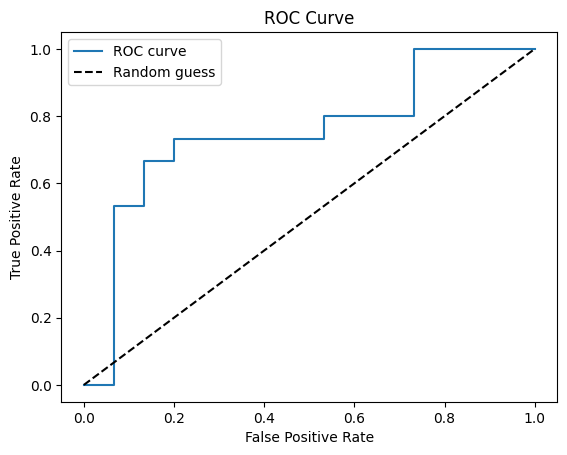

AUC score: 0.7511111111111111


In [ ]:
import pandas as pd
from sklearn.metrics import (confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score,
                             precision_score, recall_score, roc_curve, roc_auc_score)
import matplotlib.pyplot as plt

# Load the Excel file into a Pandas dataframe
df = pd.read_excel('fight_detection_lstm-features_009-0_447_lstm128_droput_05_dense64_test_results.xlsx', sheet_name='Classification results')

# Get the true labels and scores for the positive class ('fight')
y_true = df['Known'] == 'fight'
y_score = df['fight']

# Calculate the false positive rate and true positive rate for ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Calculate the AUC score
auc_score = roc_auc_score(y_true, y_score)

# Print the results
print('AUC score:', auc_score)


In [ ]:
fpr

array([0.        , 0.33333333, 1.        ])

In [ ]:
!pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Clasifying

```
! python clasify.py 43 2 lstm-features.hdf5 forehand.avi
```



In [ ]:
!python clasify.py 20 2  data/checkpoints/lstm-features.003-0.569.hdf5 data/test/fight/fi005.mp4

2023-03-22 18:50:58.793013: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 18:51:00.421696: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.9/dist-packages/cv2/../../lib64:/usr/local/lib/python3.9/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-03-22 18:51:00.421815: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /u

In [ ]:
import os
from PIL import Image
import pandas as pd

# Define the folder path where the images are stored
folder_path = '/content/drive/MyDrive/fight-detection/data/train/fight'

# Initialize a list to store the size of each image
image_size = []

# Loop through all the files in the folder
for filename in os.listdir(folder_path):
    # Check if the file is an image
    if filename.endswith('.png') or filename.endswith('.jpg'):
        # Open the image using Pillow library
        with Image.open(os.path.join(folder_path, filename)) as img:
            # Get the size of the image and append it to the list
            width, height = img.size
            image_size.append((filename, width, height))

# Convert the list to a Pandas DataFrame
df = pd.DataFrame(image_size, columns=['filename', 'width', 'height'])

# Print the DataFrame
print(df)

            filename  width  height
0     fi124-0052.jpg    128     128
1     fi124-0053.jpg    128     128
2     fi124-0054.jpg    128     128
3     fi124-0055.jpg    128     128
4     fi124-0056.jpg    128     128
...              ...    ...     ...
6259  fi132-0007.jpg    128     128
6260  fi132-0008.jpg    128     128
6261  fi132-0009.jpg    128     128
6262  fi132-0010.jpg    128     128
6263  fi132-0011.jpg    128     128

[6264 rows x 3 columns]


In [ ]:
df.describe()

,width,height
count,6264.0,6264.0
mean,128.0,128.0
std,0.0,0.0
min,128.0,128.0
25%,128.0,128.0
50%,128.0,128.0
75%,128.0,128.0
max,128.0,128.0
